<a href="https://colab.research.google.com/github/Sinha-Saurav/Bean-Leaf-Disease-Classifier/blob/main/transfer_learning(CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sauravsinhageek
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification


100%|██████████| 155M/155M [00:00<00:00, 1.19GB/s]

In [33]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [66]:
train_df = pd.read_csv("/content/bean-leaf-lesions-classification/train.csv")
val_df = pd.read_csv("/content/bean-leaf-lesions-classification/val.csv")

train_df["image:FILE"] = "/content/bean-leaf-lesions-classification/" + train_df["image:FILE"]
val_df["image:FILE"] = "/content/bean-leaf-lesions-classification/" + val_df["image:FILE"]

pd.set_option("display.max_colwidth", None)
train_df.head()


,image:FILE,category
0,/content/bean-leaf-lesions-classification/train/healthy/healthy_train.98.jpg,0
1,/content/bean-leaf-lesions-classification/train/healthy/healthy_train.148.jpg,0
2,/content/bean-leaf-lesions-classification/train/healthy/healthy_train.306.jpg,0
3,/content/bean-leaf-lesions-classification/train/healthy/healthy_train.305.jpg,0
4,/content/bean-leaf-lesions-classification/train/healthy/healthy_train.40.jpg,0


In [36]:
train_df.shape, val_df.shape

((1034, 2), (133, 2))

In [37]:
train_df["category"].unique()

array([0, 1, 2])

In [38]:
print(train_df["category"].value_counts())

category
2    348
1    345
0    341
Name: count, dtype: int64


In [39]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [40]:
class CustomImageDataset(Dataset):
  def __init__(self, dataframe, transform):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(dataframe["category"]).to(device)

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, index):
    img_path = self.dataframe.iloc[index, 0]
    label = self.labels[index]
    image = Image.open(img_path)

    if self.transform:
      image = (self.transform(image)).to(device)

    return image, label


In [41]:
train_dataset = CustomImageDataset(dataframe = train_df, transform = transform)
val_dataset = CustomImageDataset(dataframe = val_df, transform = transform)

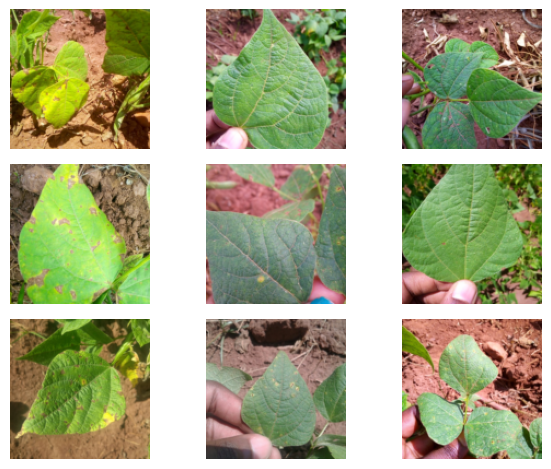

In [42]:
n_rows = 3
n_cols = 3

f, axarr = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
  for col in range(n_cols):
    image = train_dataset[np.random.randint(0, train_dataset.__len__())][0].cpu()
    axarr[row, col].imshow((image).squeeze().permute(1,2,0))
    axarr[row,col].axis("off")

plt.tight_layout()
plt.show()

In [43]:
LR = 1e-3
BATCH_SIZE = 4
EPOCHS = 20


In [44]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle = True)

In [45]:
googlenet_model = models.googlenet(weights = 'DEFAULT')

In [46]:
for param in googlenet_model.parameters():
  param.requires_grad = True

In [47]:
googlenet_model.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [48]:
num_classes = len(train_df["category"].unique())
num_classes

3

In [49]:
googlenet_model.fc = torch.nn.Linear(googlenet_model.fc.in_features, num_classes)
googlenet_model.fc

Linear(in_features=1024, out_features=3, bias=True)

In [50]:
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [51]:
loss = nn.CrossEntropyLoss()
optimizer = Adam(googlenet_model.parameters(), lr =LR)

total_loss_train_plot = []
total_acc_train_plot = []

for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0

  for inputs, labels in train_loader:
    optimizer.zero_grad()
    outputs = googlenet_model(inputs)
    train_loss = loss(outputs, labels)
    total_loss_train += train_loss.item()

    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
    total_acc_train += train_acc

    optimizer.step()

  total_loss_train_plot.append(round(total_loss_train/1000,4))
  total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__()*100,4))
  print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/1000,4)}, Train Accuracy: {round(total_acc_train/train_dataset.__len__()*100,4)}")


Epoch 1/20, Train Loss: 0.224, Train Accuracy: 62.5725
Epoch 2/20, Train Loss: 0.1979, Train Accuracy: 67.9884
Epoch 3/20, Train Loss: 0.1439, Train Accuracy: 77.853
Epoch 4/20, Train Loss: 0.1451, Train Accuracy: 78.7234
Epoch 5/20, Train Loss: 0.1219, Train Accuracy: 81.9149
Epoch 6/20, Train Loss: 0.0967, Train Accuracy: 87.1373
Epoch 7/20, Train Loss: 0.082, Train Accuracy: 88.8781
Epoch 8/20, Train Loss: 0.0695, Train Accuracy: 90.2321
Epoch 9/20, Train Loss: 0.0628, Train Accuracy: 91.1025
Epoch 10/20, Train Loss: 0.0614, Train Accuracy: 91.6828
Epoch 11/20, Train Loss: 0.0566, Train Accuracy: 92.4565
Epoch 12/20, Train Loss: 0.0542, Train Accuracy: 92.3598
Epoch 13/20, Train Loss: 0.0571, Train Accuracy: 91.6828
Epoch 14/20, Train Loss: 0.0489, Train Accuracy: 93.7137
Epoch 15/20, Train Loss: 0.0434, Train Accuracy: 94.4874
Epoch 16/20, Train Loss: 0.0302, Train Accuracy: 96.0348
Epoch 17/20, Train Loss: 0.0418, Train Accuracy: 94.971
Epoch 18/20, Train Loss: 0.0218, Train Accur

In [52]:
with torch.inference_mode():
  total_loss_test = 0
  total_acc_test = 0

  for inputs, labels in val_loader:
    prediction = googlenet_model(inputs)

    acc = (torch.argmax(prediction, axis=1)==labels).sum().item()
    total_acc_test+=acc

In [53]:
print(round(total_acc_test/val_dataset.__len__()*100,2))

91.73


## Inference

In [55]:
with open("/content/bean-leaf-lesions-classification/classname.txt",'r') as f:
  class_names = [line.strip() for line in f]

print("class names", class_names)

class names ['healthy', 'angular_leaf_spot', 'bean_rust']


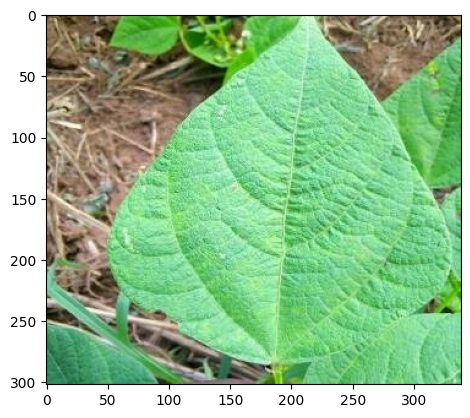

Prediction:

tensor([[ 5.4077, -8.3450,  1.0402]], device='cuda:0')


'healthy'

In [65]:
def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = (transform(image)).to(device)

  googlenet_model.eval()
  with torch.no_grad():
    output = googlenet_model(image.unsqueeze(0))
    print(output)
    output = torch.argmax(output, axis=1).item()
    return class_names[output]



image = Image.open("/content/A-healthy-bean-leaf.png")
plt.imshow(image)
plt.show()

print("Prediction:\n")
predict_image("/content/A-healthy-bean-leaf.png")

In [58]:
torch.save(googlenet_model.state_dict(), "googlenet_model.pth")

In [59]:
from google.colab import files
files.download("/content/bean-leaf-lesions-classification/classname.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>